In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph 
from copy import deepcopy
import pickle
from plot_module import plot_neuron_graph

from graph_from_swc import edge_length, edge_volume, volume_by_type, nxgraph_from_swc_df, remove_transition_nodes

In [2]:
nodetype_dict = {1:'soma', 2:'axon', 3:'dendrite', 4:'dendrite'}
color_dict = {1:'red', 2:'blue', 3:'limegreen', 4:'limegreen'}

In [31]:
name = 'm_hippocampus_NMO_97827'
file = f'neuron_shape_data/{name}.txt'
full_swc_df = pd.read_csv(file, sep = ' ', header=None, skipinitialspace = True)
full_swc_df.columns = ['comp_id','type','x','y','z','radius','parent_id']
full_swc_df

,comp_id,type,x,y,z,radius,parent_id
0,1,1,0.00,0.00,0.00,4.049,-1
1,4,2,-2.64,-0.14,-0.24,0.195,1
2,5,2,-4.53,-0.86,-0.06,0.195,4
3,6,2,-5.46,-1.92,-0.92,0.195,5
4,7,2,-7.01,-3.53,-1.95,0.145,6
...,...,...,...,...,...,...,...
312,315,3,9.16,54.53,0.50,0.145,314
313,316,3,9.95,55.45,0.19,0.145,315
314,317,3,11.30,55.90,0.21,0.145,316
315,318,3,12.18,57.51,0.44,0.145,317


In [4]:
# # distance between two points
# def edge_length(input_df, node_id, parent_id):
#     node_row = input_df.loc[input_df['comp_id'] == node_id]
#     parent_row = input_df.loc[input_df['comp_id'] == parent_id]
    
#     node_xyz = np.array([node_row['x'], node_row['y'], node_row['z']]).flatten()
#     parent_xyz = np.array([parent_row['x'], parent_row['y'], parent_row['z']]).flatten()
    
#     # 3d euclidean distance
#     return np.round(np.linalg.norm(node_xyz-parent_xyz), 4)

# # approximate the volume of an edge using a cylinder (produces identical results to neuromorpho)
# def edge_volume(input_df, node_id, parent_id):
#     node_row = input_df.loc[input_df['comp_id'] == node_id]
#     parent_row = input_df.loc[input_df['comp_id'] == parent_id]
    
#     node_xyz = np.array([node_row['x'], node_row['y'], node_row['z']]).flatten()
#     parent_xyz = np.array([parent_row['x'], parent_row['y'], parent_row['z']]).flatten()
    
#     # volume of cylinder
#     h = np.linalg.norm(node_xyz-parent_xyz)
#     r = float(node_row['radius'])
#     return np.round(np.pi*r*r*h, 4)
    
# def volume_by_type(G):
#     edge_volumes_and_types = ([(e[2]['volume'], int(e[2]['edgetype'])) for e in G.edges(data=True)])
    
#     soma_volume = (4/3)*np.power(list(G.nodes(data = True))[0][1]['radius'], 3)*np.pi
#     axon_volume = np.sum([element[0] for element in edge_volumes_and_types if element[1] == 2])
#     dendrite_volume = np.sum([element[0] for element in edge_volumes_and_types if element[1] != 2])
    
#     absolute_volumes = np.array([soma_volume, axon_volume, dendrite_volume]).round(2)
#     relative_volumes = np.round(absolute_volumes/np.sum(absolute_volumes), 2)

#     print('absolute volumes (s, a, d)', absolute_volumes)
#     print('relative volumes (s, a, d)', relative_volumes)

In [5]:
# def nxgraph_from_swc_df(swc_df):
#     G = nx.Graph()
    
#     # add nodes
#     for index, row in swc_df.iterrows():
#         G.add_node(
#             str(int(row['comp_id'])), 
#             nodetype = int(row['type']), 
#             radius = float(row['radius']),
#             xy = (float(row['x']), float(row['y']))
#         )
    
#     # add edges
#     for index, row in swc_df.iterrows():
#         if index > 0:
#             G.add_edge(
#                 str(int(row['comp_id'])), str(int(row['parent_id'])), 
#                 volume = edge_volume(swc_df, int(row['comp_id']), int(row['parent_id'])),
#                 len = edge_length(swc_df, int(row['comp_id']), int(row['parent_id'])),
#                 edgetype = int(row['type'])      
#             )
    
#     return G

In [32]:
neuron_graph_full = nxgraph_from_swc_df(full_swc_df)
volume_by_type(neuron_graph_full)

absolute volumes (s, a, d) [278.06   8.73  27.24]
relative volumes (s, a, d) [0.89 0.03 0.09]


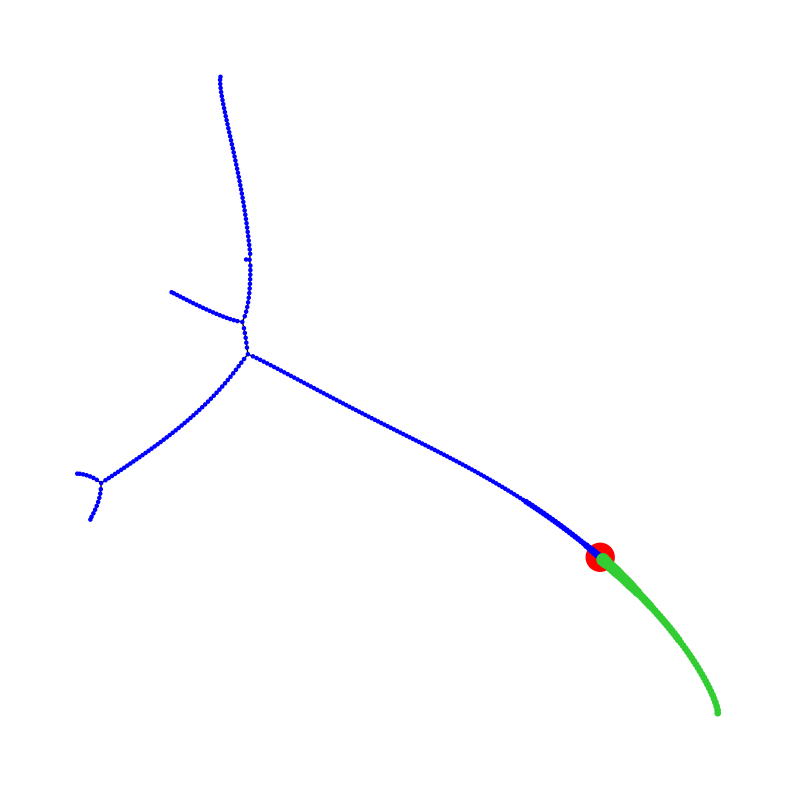

In [33]:
plot_neuron_graph(neuron_graph_full)

In [8]:
# def remove_transition_nodes(G, swc_df):
#     out_df = deepcopy(swc_df)

#     # find leaf, root, and branch nodes
#     all_nodes = list(G.nodes())
#     leaf_nodes = [x for x in G.nodes() if G.degree(x)==1]
#     root_node = [all_nodes[0]]; leaf_nodes = [node for node in leaf_nodes if node not in root_node]
#     branch_nodes = [x for x in G.nodes() if len(nx.descendants_at_distance(G, x, 1)) > 2]
    
#     # find remaining nodes, which are transitions.
#     transition_nodes = list(set(G.nodes()) - set(leaf_nodes) - set(root_node) - set(branch_nodes))
    
#     # go through the graph, removing the transition nodes
#     for tran_node_id in transition_nodes:
        
#         tran_node_row = out_df.loc[out_df['comp_id'] == int(tran_node_id)]
#         prnt_node_id = int(tran_node_row['parent_id'])
        
#         prnt_node_row = out_df.loc[out_df['comp_id'] == prnt_node_id]
#         chld_node_row = out_df.loc[out_df['parent_id'] == int(tran_node_id)]

#         # rewrite parent of child node to parent of transition node
#         out_df.loc[chld_node_row.index, 'parent_id'] = prnt_node_id

#         # delete the row corresponding to the node
#         out_df = out_df.drop(tran_node_row.index)
            
    
#     return out_df

In [34]:
filtered_swc_df = remove_transition_nodes(neuron_graph_full, full_swc_df)
filtered_swc_df

,comp_id,type,x,y,z,radius,parent_id
0,1,1,0.00,0.00,0.00,4.049,-1
113,116,2,-243.93,61.60,54.64,0.050,1
162,165,2,-266.81,38.83,3.28,0.050,116
171,174,2,-256.33,34.58,-5.85,0.050,165
178,181,2,-284.91,59.96,8.87,0.050,165
184,187,2,-240.20,63.19,65.95,0.050,116
205,208,2,-197.44,66.71,83.56,0.050,187
218,221,2,-245.03,52.83,67.03,0.050,187
262,265,2,-366.01,42.47,76.00,0.050,221
263,266,2,-244.23,50.83,66.43,0.050,221


In [35]:
neuron_graph_filtered = nxgraph_from_swc_df(filtered_swc_df)
volume_by_type(neuron_graph_filtered)

absolute volumes (s, a, d) [278.06   4.36   3.95]
relative volumes (s, a, d) [0.97 0.02 0.01]


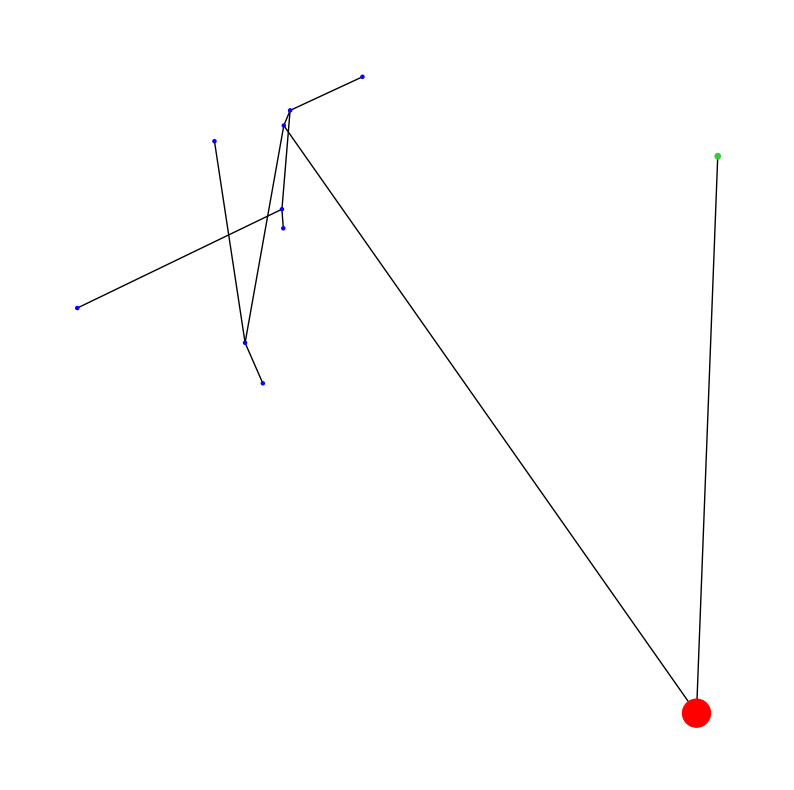

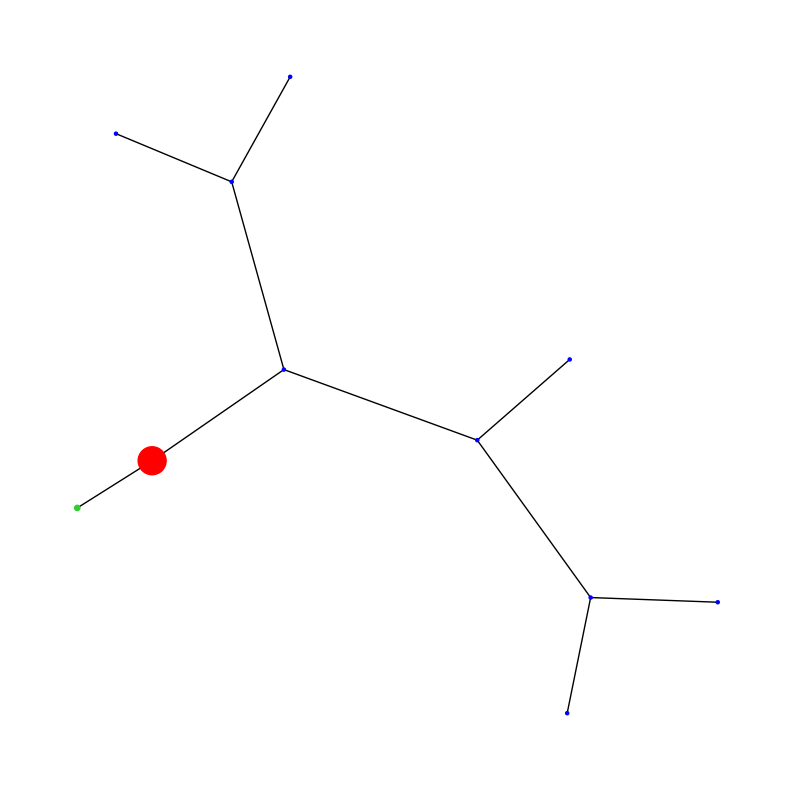

In [36]:
plot_neuron_graph(neuron_graph_filtered, realxy=True)

In [37]:
G = neuron_graph_filtered
central_node = '1'

def get_branches(graph, root):
    # List to store branches
    branches = []
    # Depth-first search starting from the root
    for edge in nx.dfs_edges(graph, source=root):
        if not branches or edge[0] == root:
            # Start a new branch
            branches.append([edge])
        else:
            # Continue the current branch
            branches[-1].append(edge)
    return branches

edges_in_each_branch = get_branches(G, central_node)

for branch in edges_in_each_branch:
    print(np.sum([data['volume'] for u, v, data in G.edges(data = True) if (u,v) in branch]))

4.3583
3.9451


(0.0, 0.14975)

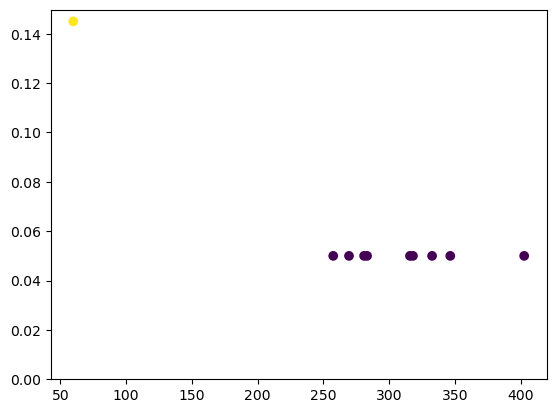

In [38]:
distance_to_soma = [nx.dijkstra_path_length(G, source='1', target=node, weight='len') for node in G.nodes if node != '1']
diameter_at_node = [data['radius'] for node, data in G.nodes(data = True) if node != '1']
node_type = [data['nodetype'] for node, data in G.nodes(data = True) if node != '1']
plt.scatter(distance_to_soma, diameter_at_node, c = node_type)
plt.ylim(0,None)

In [39]:
[f"{u}-{v}:{data['len']}:{data['volume']}" for u, v, data in G.edges(data = True) if data['edgetype'] == 2]

['1-116:257.4528:2.022',
 '116-165:60.6615:0.4764',
 '116-187:12.0149:0.0944',
 '165-174:14.5344:0.1142',
 '165-181:28.3784:0.2229',
 '187-208:46.378:0.3643',
 '187-221:11.4815:0.0902',
 '221-265:121.7536:0.9563',
 '221-266:2.2361:0.0176']

In [14]:
diameter_at_node

[0.035,
 0.035,
 0.145,
 0.07,
 0.07,
 0.035,
 0.035,
 0.18,
 0.18,
 0.18,
 0.07,
 0.145,
 0.145,
 0.145,
 0.145,
 0.145,
 0.145,
 0.145,
 0.145,
 0.145,
 0.145,
 0.11,
 0.11,
 0.07,
 0.07,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11]

In [40]:
# with open(f'neuron_shape_data/{name}.pkl', 'wb') as f:
#     pickle.dump(neuron_graph_filtered, f)